In [1]:
import os, warnings
import numpy as np
import pandas as pd
import scanpy as sc
import anndata as ad
import matplotlib.pyplot as plt
from lifelines import KaplanMeierFitter
from lifelines.statistics import logrank_test
from typing import Tuple
warnings.simplefilter('ignore', FutureWarning)

In [2]:
pth_data = os.path.join('..', 'data', 'modeling', 'predict')
pth_out = os.path.join('..', 'figures', 'survival')

In [3]:
adata = sc.read_h5ad(os.path.join(pth_data, 'TCGA.h5ad'))
adata

AnnData object with n_obs × n_vars = 10496 × 856
    obs: '_PATIENT', 'cancer type abbreviation', 'age_at_initial_pathologic_diagnosis', 'gender', 'race', 'ajcc_pathologic_tumor_stage', 'clinical_stage', 'histological_type', 'histological_grade', 'initial_pathologic_dx_year', 'menopause_status', 'birth_days_to', 'vital_status', 'tumor_status', 'last_contact_days_to', 'death_days_to', 'cause_of_death', 'new_tumor_event_type', 'new_tumor_event_site', 'new_tumor_event_site_other', 'new_tumor_event_dx_days_to', 'treatment_outcome_first_course', 'margin_status', 'residual_tumor', 'OS', 'OS.time', 'DSS', 'DSS.time', 'DFI', 'DFI.time', 'PFI', 'PFI.time', 'Redaction', 'source', 'latent_z'

In [4]:
cancer_types_dict = {
    'ACC'  : 'Adrenocortical Cancer',
    'BLCA' : 'Bladder Cancer',
    'BRCA' : 'Breast Cancer',
    'CESC' : 'Cervical Cancer',
    'CHOL' : 'Bile Duct Cancer',
    'COAD' : 'Colon Cancer',
    'DLBC' : 'Large B-cell Lymphoma',
    'ESCA' : 'Esophageal Cancer',
    'GBM'  : 'Glioblastoma',
    'HNSC' : 'Head and Neck Cancer',
    'KICH' : 'Kidney Chromophobe',
    'KIRC' : 'Kidney Clear Cell Carcinoma',
    'KIRP' : 'Kidney Papillary Cell Carcinoma',
    'LAML' : 'Acute Myeloid Leukemia',
    'LGG'  : 'Lower Grade Glioma',
    'LIHC' : 'Liver Cancer',
    'LUAD' : 'Lung Adenocarcinoma',
    'LUSC' : 'Lung Squamous Cell Carcinoma',
    'MESO' : 'Mesothelioma',
    'OV'   : 'Ovarian Cancer',
    'PAAD' : 'Pancreatic Cancer',
    'PCPG' : 'Pheochromocytoma & Paraganglioma',
    'PRAD' : 'Prostate Cancer',
    'READ' : 'Rectal Cancer',
    'SARC' : 'Sarcoma',
    'SKCM' : 'Melanoma',
    'STAD' : 'Stomach Cancer',
    'TGCT' : 'Testicular Cancer',
    'THCA' : 'Thyroid Cancer',
    'THYM' : 'Thymoma',
    'UCEC' : 'Endometrioid Cancer',
    'UCS'  : 'Uterine Carcinosarcoma',
    'UVM'  : 'Ocular Melanomas'}

survival_types_dict = {
    'OS'  : 'Overall Survival',
    'DSS' : 'Disease-Specific Survival',
    'DFI' : 'Disease-Free Interval',
    'PFI' : 'Progresssion-Free Interval'}

In [5]:
# survival analysis wrapper function
def fit_survival(adata: ad.AnnData,
                 stratify_by: str,
                 cancer_type: str,
                 survival_type: str,
                 t_max: float | None = None,
                 q_low: float = .33,
                 q_high: float = .66,
                 title: str | None = None,
                 ylabel: str | None = None,
                 **kwargs
                 ) -> Tuple[plt.Axes, float] | None:

    # select cancer type & gene
    col = 'cancer type abbreviation'
    msk = (adata.obs[col] == cancer_type)
    adata = adata[msk].copy()
    df = adata.obs.copy()
    X = adata[:, stratify_by].X.toarray()
    df[stratify_by] = X.squeeze()

    # deduplicate patients
    survival_type_time = survival_type + '.time'
    agg_dict = {survival_type      : 'first',
                survival_type_time : 'first',
                stratify_by        : 'mean'}
    cols = list(agg_dict.keys())
    df[cols] = df[cols].astype(float)
    df = df.groupby('_PATIENT').agg(agg_dict).dropna(subset = cols)
    df[survival_type_time] /= 365.

    if not df.empty:
        # stratify patients
        X = df[stratify_by].copy()
        df_low = df.loc[X < X.quantile(q_low)]
        df_high = df.loc[X > X.quantile(q_high)]

        if not df_low.empty and not df_high.empty:
            # plot survival
            _, ax = plt.subplots(1, 1, **kwargs)
            kmf = KaplanMeierFitter()
            if t_max: timeline = np.arange(0, t_max + 1e-3, 7/365)
            else: timeline = None
            for label, _df_ in (('Low', df_low), ('High', df_high)):
                kmf.fit(_df_[survival_type_time], _df_[survival_type],
                        timeline = timeline, label = label)
                ax = kmf.plot_survival_function(ax = ax)

            # significance
            res = logrank_test(df_low[survival_type_time],
                               df_high[survival_type_time],
                               df_low[survival_type],
                               df_high[survival_type])
            pval = res.p_value

            # axes ticks/labels
            yticks = np.arange(0, 1.1, .2)
            yticklabels = (yticks * 100).astype(int)
            ax.set_yticks(yticks, yticklabels)
            ax.set_ylim(yticks[0] - .03, yticks[-1] + .03)
            if ylabel is None: ylabel = survival_type
            ax.set_ylabel(f'{ylabel} (%)')
            ax.set_xlabel('Years')

            # legend/title/pval
            leg = ax.legend(bbox_to_anchor = (1., .7), frameon = False)
            leg.set_title(stratify_by, prop = {'style' : 'italic'})
            if title is None: title = cancer_type
            ax.set_title(title)
            ax.text(.5, .1, fr'$p =$ {pval:.2g}', transform = ax.transAxes,
                    bbox = {'boxstyle' : 'round', 'fc' : 'w', 'ec' : 'gray'},
                    ha = 'center', va = 'center')
            return ax, pval

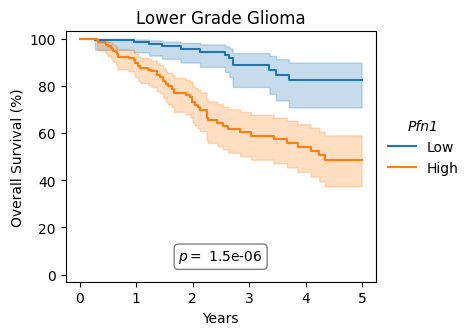

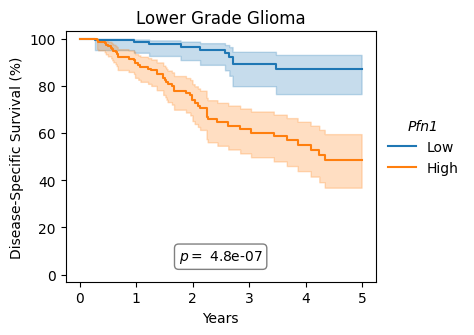

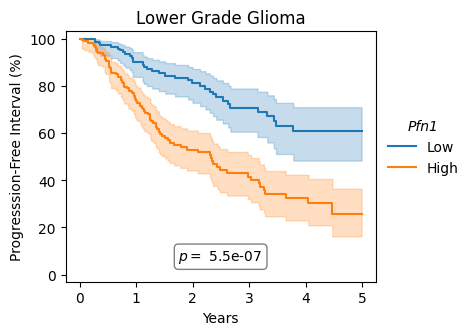

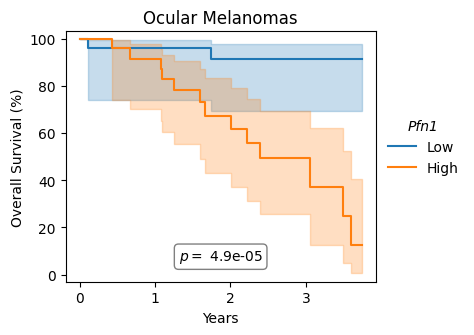

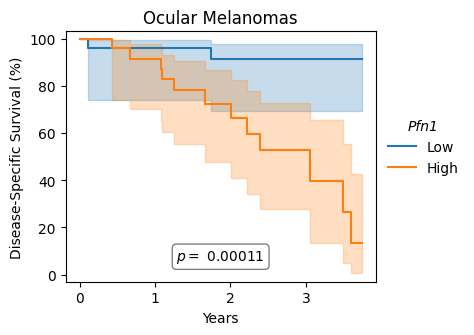

In [6]:
gene = 'Pfn1'  # plot survival
pval_thresh, t_max = 1e-3, {'LGG' : 5, 'UVM' : 3.75}
for cancer_type, cancer_name in cancer_types_dict.items():
    if cancer_type in t_max: _t_max_ = t_max[cancer_type]
    else: _t_max_ = None
    for survival_type, survival_name in survival_types_dict.items():
        out = fit_survival(adata, gene,
                           cancer_type,
                           survival_type,
                           t_max = _t_max_,
                           title = cancer_name,
                           ylabel = survival_name,
                           figsize = (4, 3.25))
        if out and out[1] < pval_thresh:
            fn = os.path.join(pth_out, gene, f'{cancer_type}_{survival_type}.pdf')
            plt.savefig(fn, bbox_inches = 'tight')
        elif out: plt.close()